In [1]:
from espnet2.bin.cyclic_asr_tts_demo import CyclicASRTTS
import glob
import os
import numpy as np
import kaldiio
import torch
import librosa
import librosa.display
from pathlib import Path
import os


asrtts = CyclicASRTTS.from_pretrained(
    model_tag = 'tjysdsg/11692_cyclic_asr_tts_gumbel_softmax_init',
)

Fetching 22 files:   0%|          | 0/22 [00:00<?, ?it/s]

/ocean/projects/cis210027p/jtang1/cyclic_asr/espnet2/gan_tts/vits/monotonic_align/__init__.py:19: UserWarning: Cython version is not available. Fallback to 'EXPERIMETAL' numba version. If you want to use the cython version, please build it as follows: `cd espnet2/gan_tts/vits/monotonic_align; python setup.py build_ext --inplace`
  warnings.warn(


In [2]:
def display_audio(wav: torch.Tensor):
    from IPython.display import display, Audio
    display(Audio(wav, rate=16000))


def get_spembs(spk):
    xvectors = {k: v for k, v in kaldiio.load_ark("dump/xvector/train_clean_360/spk_xvector.ark")}
    spembs = xvectors[spk]
    return torch.as_tensor(spembs).unsqueeze(0)  # (1, D)


def get_rand_spembs():
    # X-vector selection
    xvectors = {k: v for k, v in kaldiio.load_ark("dump/xvector/train_clean_360/spk_xvector.ark")}
    spks = list(xvectors.keys())

    # randomly select speaker
    random_spk_idx = np.random.randint(0, len(spks))
    spk = spks[random_spk_idx]
    spembs = xvectors[spk]
    print(f"Got x-vector from speaker: {spk}")
    return torch.as_tensor(spembs).unsqueeze(0)  # (1, D)

Utterance: 1112-1043-0022
Speaker: 1112-1043


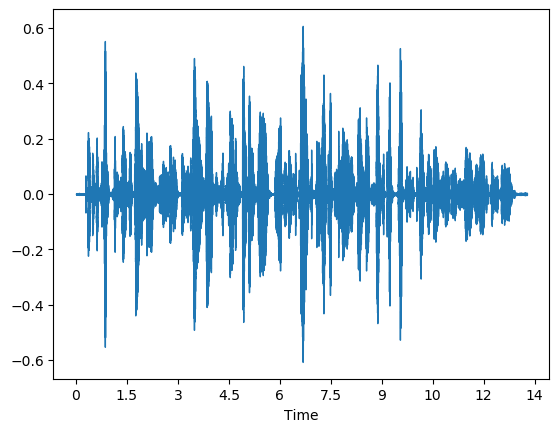

In [3]:
# load text
utt2text = {}
with open('dump/raw/train_clean_360/text') as f:
    for line in f:
        utt, text = line.rstrip('\n').split(maxsplit=1)
        utt2text[utt] = text

audio = '/ocean/projects/cis210027p/jtang1/vits_cyclic/dump/raw/org/train_clean_360/data/format.1/data_wav/1112-1043-0022.wav'
utt = Path(audio).name.split('.')[0]
print(f'Utterance: {utt}')
spk = utt.rsplit('-', maxsplit=1)[0]
print(f'Speaker: {spk}')

wav, rate = librosa.load(audio, sr=16000)
librosa.display.waveshow(wav, sr=rate)
display_audio(wav)

In [4]:
speech = torch.as_tensor(wav).unsqueeze(0)
speech_lengths = torch.as_tensor([speech.shape[1]], dtype=torch.long)

text_str = utt2text[utt]
sudo_text = text_str
# sudo_text = '...'

spembs = get_spembs(spk)
# spembs = get_rand_spembs()

res = asrtts(
    speech=speech,
    text=text_str,
    sudo_text=sudo_text,
    spembs=spembs,
)

out_wav = res['wav']
display_audio(out_wav)

asr_hyp = res['asr_hyps'].squeeze()
asr_hyp = asrtts.tokenizer.tokens2text(asrtts.converter.ids2tokens(asr_hyp))

print(f'text: {text_str}')
print(f'pseudo text: {sudo_text}')
print('-' * 80)
print(f'ASR hypothesis: {asr_hyp}')

/tmp/ipykernel_2888/2549256109.py:9: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755849709/work/torch/csrc/utils/tensor_numpy.cpp:178.)
  return torch.as_tensor(spembs).unsqueeze(0)  # (1, D)
/ocean/projects/cis210027p/jtang1/cyclic_asr/espnet2/layers/stft.py:164: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'

text: PEOPLE THAT TRUST THEMSELVES A DOZEN MILES FROM THE CITY IN STRANGE HOUSES WITH SERVANTS THEY DON'T KNOW NEEDN'T BE SURPRISED IF THEY WAKE UP SOME MORNING AND FIND THEIR THROATS CUT AFTER WHICH CAREFULLY VEILED SARCASM LIDDY RELAPSED INTO GLOOM
pseudo text: PEOPLE THAT TRUST THEMSELVES A DOZEN MILES FROM THE CITY IN STRANGE HOUSES WITH SERVANTS THEY DON'T KNOW NEEDN'T BE SURPRISED IF THEY WAKE UP SOME MORNING AND FIND THEIR THROATS CUT AFTER WHICH CAREFULLY VEILED SARCASM LIDDY RELAPSED INTO GLOOM
--------------------------------------------------------------------------------
ASR hypothesis: PMOPLE THAT TRWPT THEMSEOVES A DOZEN MILRC FR'M HHE CITY IN STRANGE HSUSESLWITH SERVANTS THEY DON T KNOW NEEDN'T BE SURPRIQED IF THEY WAKE<blank>UP SOME MORNIBG AND FIND THEIR THROATS CUT AFTER WHICH CAREFULLY VEILEDJSARCASM LADYY RNLAPS<blank>D INTOCGLOOM<sos/eos>


In [5]:
speech = torch.as_tensor(wav).unsqueeze(0)
speech_lengths = torch.as_tensor([speech.shape[1]], dtype=torch.long)

text_str = utt2text[utt]
sudo_text = text_str
# sudo_text = '...'

spembs = get_spembs(spk)
# spembs = get_rand_spembs()

res = asrtts(
    speech=speech,
    text=text_str,
    sudo_text=sudo_text,
    spembs=spembs,
    reinforce=True,
    reinforce_sample_size=4,
)

print(f'text: {text_str}')
print(f'pseudo text: {sudo_text}')
print('-' * 80)


asr_hyp = res['asr_hyps'].squeeze()
hyp = asrtts.tokenizer.tokens2text(asrtts.converter.ids2tokens(asr_hyp))
print(f'ASR best hyp: {hyp}')
print('-' * 80)


out_wavs = res['wavs']
sampled_text = res['sampled_text'].squeeze()
for i in range(sampled_text.shape[0]):
    hyp = asrtts.tokenizer.tokens2text(asrtts.converter.ids2tokens(sampled_text[i]))
    print(f'ASR hyp sample {i}: {hyp}')

    display_audio(out_wavs[i])
    print('-' * 80)

reinforce_sample_size: 4
text: PEOPLE THAT TRUST THEMSELVES A DOZEN MILES FROM THE CITY IN STRANGE HOUSES WITH SERVANTS THEY DON'T KNOW NEEDN'T BE SURPRISED IF THEY WAKE UP SOME MORNING AND FIND THEIR THROATS CUT AFTER WHICH CAREFULLY VEILED SARCASM LIDDY RELAPSED INTO GLOOM
pseudo text: PEOPLE THAT TRUST THEMSELVES A DOZEN MILES FROM THE CITY IN STRANGE HOUSES WITH SERVANTS THEY DON'T KNOW NEEDN'T BE SURPRISED IF THEY WAKE UP SOME MORNING AND FIND THEIR THROATS CUT AFTER WHICH CAREFULLY VEILED SARCASM LIDDY RELAPSED INTO GLOOM
--------------------------------------------------------------------------------
ASR best hyp: PEOPLE THAT TRUST THEMSELVES A DOZEN MILES FROM THE CITY IN STRANGE HOUSES WITH SERVANTS THEY DON'T KNOW NEEDN'T BE SURPRISED IF THEY WAKE UP SOME MORNING AND FIND THEIR THROATS CUT AFTER WHICH CAREFULLY VEILED SARCASM LADYY RELAPSED INTO GLOOM<sos/eos>
--------------------------------------------------------------------------------
ASR hyp sample 0: PEOPEE THAT TRUSTS

--------------------------------------------------------------------------------
ASR hyp sample 1: PETPLE THATLTRUST EHEMSELVES A DOZEN MIUE<blank> FKOM THN CITY INZSTRANGE HYUSES WITH SERVANTS THEYLDVN'T KNOW NEZDT'T BE SURPRIYE' IF THEY WAKE UPS'OME IORNING AND VIND THEIF THROATS CUT AFTED WHICD CAREFQULY LEILED SARCASM LADYY RELAGSED INTO GLOOM<sos/eos>


--------------------------------------------------------------------------------
ASR hyp sample 2: PEFPLE THAT HRUST YHAMSELDES Q DZXEN YILES FR M THE CITY IN STRANGE HOUSES NITH SERVPNTS THEY KON'T KNOW NEEDN'T BE SURPRISED IF THEY<unk>WBKT UP SOME MORNINC AND FIND THEIR THROATT CUT AFTERSWH CHNCARAFELLY IEILED SARCASM LADYY RELAPSKD INTO YLOOM<sos/eos>


--------------------------------------------------------------------------------
ASR hyp sample 3: PEO<unk>LE THAT TRUST THEMSELVES P DJZEN MWLES FRO<blank> THE CITY IN STRANGE HOUS S WATH SERVANTS THEY DON'T KNOW NEEDN'T BE SURPRISED IF TXEY WAKE UP SOME MORNING AND FINC THEIR THROATI CUT AFTER WHICH CAREFULLY VEILED SYRCASMCLADYIEREZAPSED CNTO GLOOM<sos/eos>


--------------------------------------------------------------------------------
